In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [7]:
#Converts the column pickup_datetime (string format) into a datetime object.
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

In [8]:
# Calculate distance between pickup and dropoff locations using Haversine formula
#“We calculate the distance between pickup and dropoff using the Haversine formula, which finds the shortest path over the Earth’s surface.
#First, we convert latitude and longitude differences into radians. Then we use trigonometric functions to calculate the angle between the points. 
#Finally, we multiply the angle by Earth’s radius to get the distance in kilometers. This distance is a key feature for predicting the fare.”
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

df['distance'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [9]:
# Drop columns that won't be used
df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'key'], axis=1, inplace=True)
df.head()


,Unnamed: 0,fare_amount,passenger_count,hour,day,month,year,distance
0,24238194,7.5,1,19,7,5,2015,1.683323
1,27835199,7.7,1,20,17,7,2009,2.457590
2,44984355,12.9,1,21,24,8,2009,5.036377
3,25894730,5.3,3,8,26,6,2009,1.661683
4,17610152,16.0,5,17,28,8,2014,4.475450


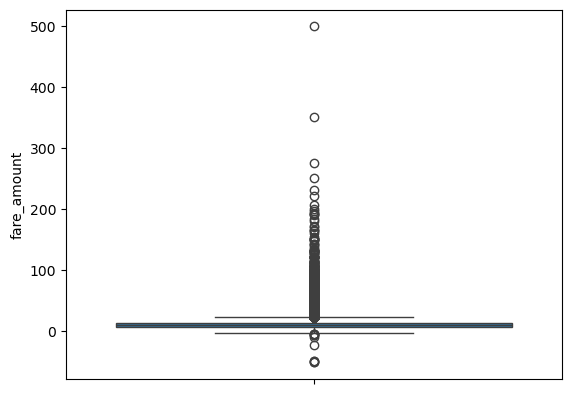

In [10]:
sns.boxplot(df["fare_amount"])
plt.show()

In [11]:
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['fare_amount'] >= lower_limit) & (df['fare_amount'] <= upper_limit)]


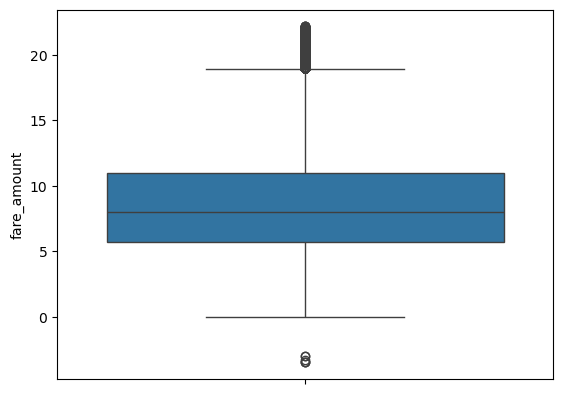

In [12]:
sns.boxplot(df["fare_amount"])
plt.show()

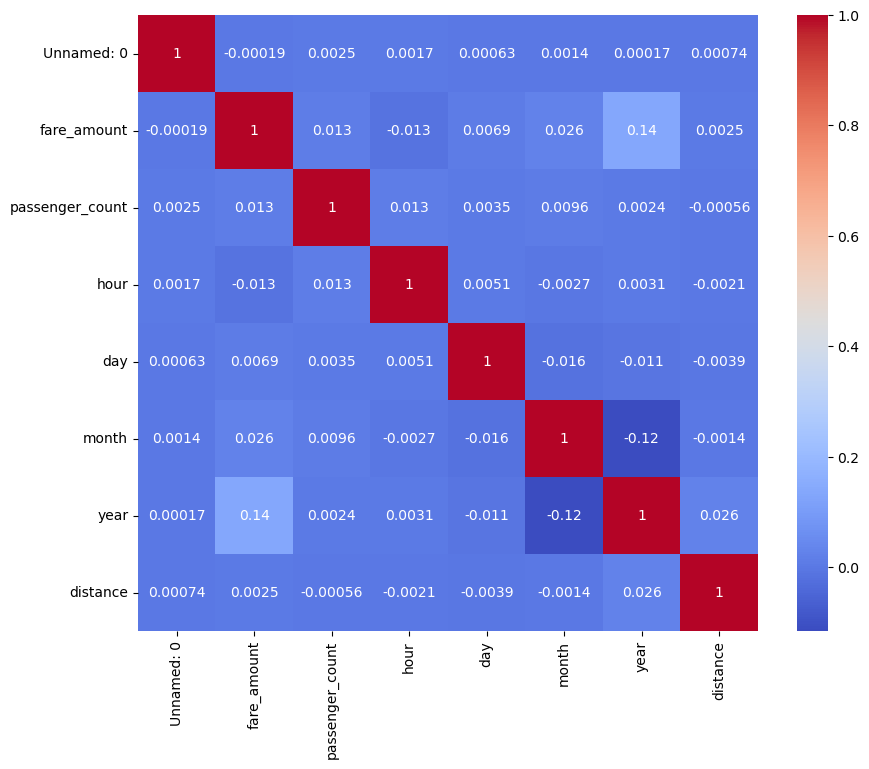

In [13]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [14]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lin = lr.predict(X_test)

In [17]:
rr = Ridge(alpha=1.0)
rr.fit(X_train, y_train)
y_pred_ridge = rr.predict(X_test)

In [18]:
la = Lasso(alpha=0.1)
la.fit(X_train, y_train)
y_pred_lasso = la.predict(X_test)

In [19]:
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

In [20]:
# Evaluate Linear Regression
r2_lin, rmse_lin = evaluate(y_test, y_pred_lin)
print(f'Linear Regression - R2: {r2_lin}, RMSE: {rmse_lin}')

Linear Regression - R2: 0.021399834712952814, RMSE: 4.092293158999904


In [21]:
# Evaluate Ridge Regression
r2_ridge, rmse_ridge = evaluate(y_test, y_pred_ridge)
print(f'Ridge Regression - R2: {r2_ridge}, RMSE: {rmse_ridge}')

Ridge Regression - R2: 0.02139983280014346, RMSE: 4.09229316299938


In [22]:
# Evaluate Lasso Regression
r2_lasso, rmse_lasso = evaluate(y_test, y_pred_lasso)
print(f'Lasso Regression - R2: {r2_lasso}, RMSE: {rmse_lasso}')

Lasso Regression - R2: 0.020960593387544968, RMSE: 4.093211461836557
